# JOBS

Checking GPU...

PyTorch: 2.9.0+cu126
CUDA: True

Installing packages...

loading Roboflow workspace...
loading Roboflow project...
Downloaded to: /content/insulators-3

Filtered to 2352 insulator annotations
From 1624 images with insulators

Creating splits...
  baseline  :   50 images,   70 labels
  iter1     :  100 images,  144 labels
  iter2     :  200 images,  295 labels
  iter3     :  300 images,  439 labels
  full      :  800 images, 1135 labels

✅ Data ready!

Training: baseline (50 epochs)
Ultralytics 8.4.10 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/splits/baseline/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, emb

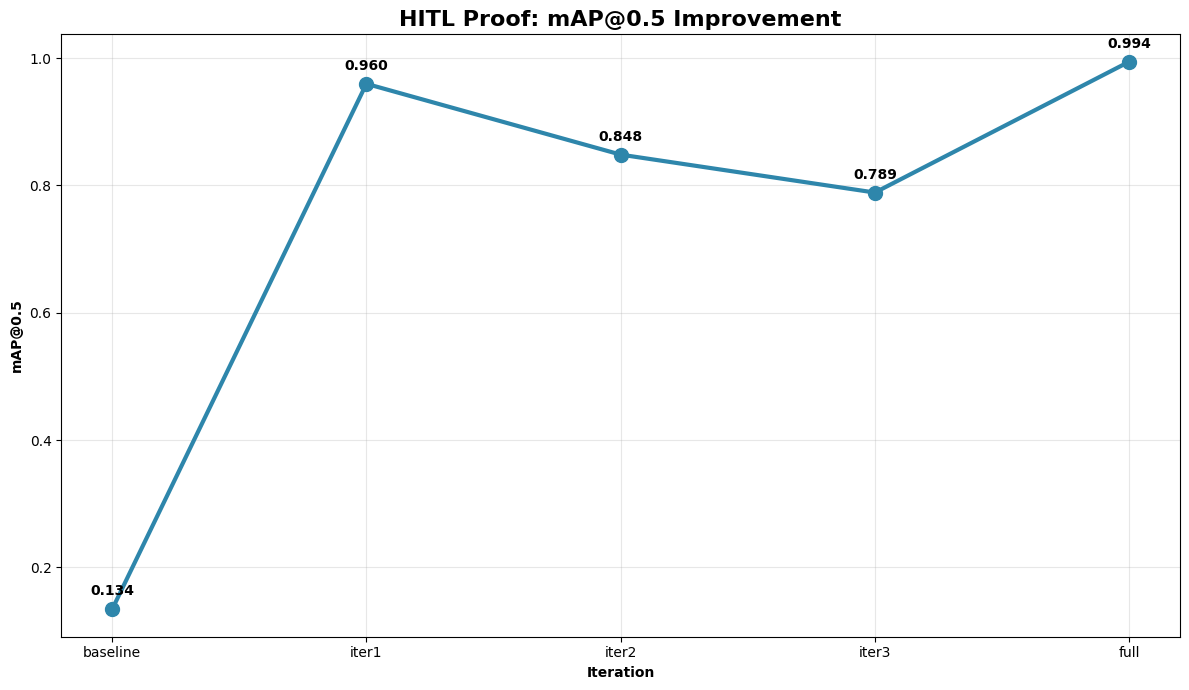


📊 Final Results:
--------------------------------------------------
baseline  : mAP@0.5 = 0.1343
iter1     : mAP@0.5 = 0.9596
iter2     : mAP@0.5 = 0.8484
iter3     : mAP@0.5 = 0.7888
full      : mAP@0.5 = 0.9943

✅ Improvement: 0.1343 → 0.9943 (+640.5%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 HITL Proof Complete!


In [24]:
#!/usr/bin/env python3
"""
HITL Proof-of-Concept Script for Colab
Run this in Colab to prove incremental learning works
"""

# Cell 1: Check GPU
print("Checking GPU...")
import subprocess
subprocess.run(['nvidia-smi'])

import torch
print(f"\nPyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

# Cell 2: Install
print("\nInstalling packages...")
subprocess.run(['pip', 'install', '-q', 'ultralytics', 'roboflow', 'matplotlib'])

# Cell 3: Download data
from roboflow import Roboflow

print("\nDownloading dataset...")
rf = Roboflow(api_key="lbXALpBLK1UO9TLPqobo")
project = rf.workspace("sofia-valdivieso-von-teuber").project("insulators-wo6lb")
dataset = project.version(3).download("coco")
DATASET_ROOT = dataset.location
print(f"Downloaded to: {DATASET_ROOT}")

# Cell 4: Prepare data
import json
import random
import shutil
from pathlib import Path

random.seed(42)

dataset_path = Path(DATASET_ROOT)
with open(dataset_path / 'train' / '_annotations.coco.json') as f:
    data = json.load(f)

# CRITICAL FIX: Filter to insulators ONLY (category_id == 1)
insulator_anns = [a for a in data['annotations'] if a['category_id'] == 1]
ann_map = {}
for ann in insulator_anns:
    if ann['image_id'] not in ann_map:
        ann_map[ann['image_id']] = []
    ann_map[ann['image_id']].append(ann)

print(f"\nFiltered to {len(insulator_anns)} insulator annotations")
print(f"From {len(ann_map)} images with insulators")

img_map = {i['id']: i for i in data['images']}
all_ids = list(ann_map.keys())
random.shuffle(all_ids)

splits = {
    'baseline': 50,
    'iter1': 100,
    'iter2': 200,
    'iter3': 300,
    'full': min(800, len(all_ids))
}

splits_dir = Path('/content/splits')
splits_dir.mkdir(exist_ok=True)

print("\nCreating splits...")
for name, size in splits.items():
    sp = splits_dir / name
    (sp / 'images').mkdir(parents=True, exist_ok=True)
    (sp / 'labels').mkdir(parents=True, exist_ok=True)
    
    labels = 0
    for img_id in all_ids[:size]:
        img = img_map[img_id]
        src = dataset_path / 'train' / img['file_name']
        if src.exists():
            shutil.copy2(src, sp / 'images' / img['file_name'])
            
            # Write YOLO labels (class 0 for all insulators)
            with open(sp / 'labels' / (Path(img['file_name']).stem + '.txt'), 'w') as f:
                for ann in ann_map[img_id]:
                    x, y, w, h = ann['bbox']
                    xc = (x + w/2) / img['width']
                    yc = (y + h/2) / img['height']
                    wn = w / img['width']
                    hn = h / img['height']
                    f.write(f"0 {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}\n")
                    labels += 1
    
    # Create data.yaml
    with open(sp / 'data.yaml', 'w') as f:
        f.write(f"""path: /content
train: splits/{name}
val: splits/{name}

names:
  0: insulators

nc: 1
""")
    
    print(f"  {name:10s}: {size:4d} images, {labels:4d} labels")

print("\n✅ Data ready!")

# Cell 5: Train all iterations
from ultralytics import YOLO
from datetime import datetime

results = []
prev_w = None
start_time = datetime.now()

for name in ['baseline', 'iter1', 'iter2', 'iter3', 'full']:
    w = prev_w if prev_w else 'yolo11n.pt'
    e = 50 if name in ['baseline', 'full'] else 30
    
    print(f"\n{'='*70}")
    print(f"Training: {name} ({e} epochs)")
    print(f"{'='*70}")
    
    m = YOLO(w)
    m.train(
        data=str(splits_dir / name / 'data.yaml'),
        epochs=e,
        imgsz=640,
        batch=16,
        device=0,
        name=name,
        patience=10
    )
    
    met = m.val()
    results.append({
        'iter': name,
        'map50': float(met.box.map50),
        'prec': float(met.box.mp),
        'rec': float(met.box.mr)
    })
    
    print(f"\n✅ {name}: mAP@0.5 = {met.box.map50:.4f}")
    prev_w = m.trainer.best

duration = (datetime.now() - start_time).total_seconds()
print(f"\n⏱️  Total time: {duration/3600:.2f} hours")

# Cell 6: Visualize
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
scores = [r['map50'] for r in results]
ax.plot(scores, marker='o', linewidth=3, markersize=10, color='#2E86AB')

for i, s in enumerate(scores):
    ax.annotate(f'{s:.3f}', (i, s), textcoords='offset points',
               xytext=(0,10), ha='center', fontweight='bold')

ax.set_xlabel('Iteration', fontweight='bold')
ax.set_ylabel('mAP@0.5', fontweight='bold')
ax.set_title('HITL Proof: mAP@0.5 Improvement', fontsize=16, fontweight='bold')
ax.set_xticks(range(len(results)))
ax.set_xticklabels([r['iter'] for r in results])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hitl_results.png', dpi=300)
plt.show()

print("\n📊 Final Results:")
print("-" * 50)
for r in results:
    print(f"{r['iter']:10s}: mAP@0.5 = {r['map50']:.4f}")

print(f"\n✅ Improvement: {scores[0]:.4f} → {scores[-1]:.4f} (+{((scores[-1]-scores[0])/scores[0]*100):.1f}%)")

# Download results
from google.colab import files
files.download('hitl_results.png')

print("\n🎉 HITL Proof Complete!")


## Statistical validation


HITL Statistical Validation: 3 Trials



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to insulators-3 in coco:: 100%|██████████| 3292/3292 [00:00<00:00, 3963.98it/s]


Dataset: 1624 images with insulators


Trial 1/3 (seed=42)

Preparing data with seed 42...
  baseline  :   50 images,   70 labels
  iter1     :  100 images,  144 labels
  iter2     :  200 images,  295 labels
  iter3     :  300 images,  439 labels
  full      :  800 images, 1135 labels
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

[Trial 1] Training baseline...
Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/cont

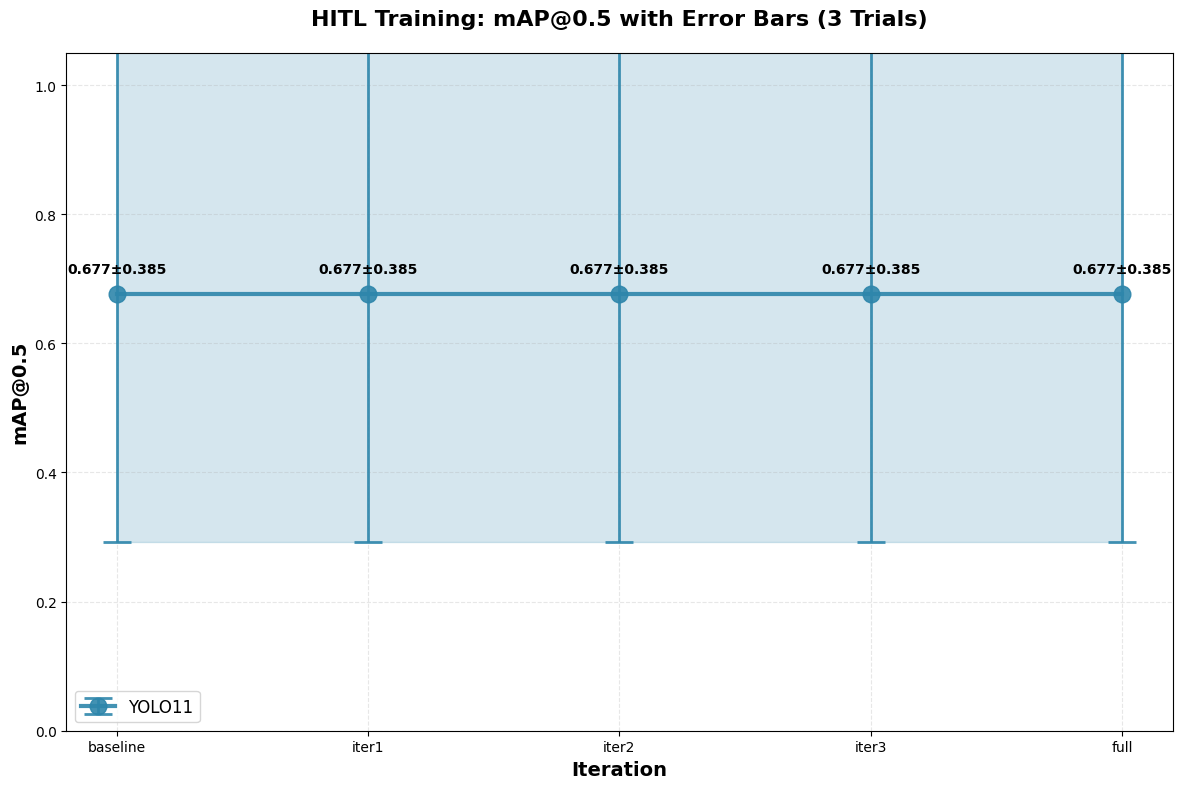


✅ Statistical validation complete!
   Results saved to:
   - aggregated_results.json
   - publication_plot_with_errorbars.png
   - results_trial_*.json (individual trials)

Statistical Significance Testing

Paired t-test: Baseline vs. Full
  Baseline: 0.6769 ± 0.3845
  Full:     0.6769 ± 0.3845
  t-statistic: nan
  p-value: nan
  ⚠️  Not significant (p = nan)

🎉 Ready for manuscript submission with statistical validation!


In [3]:
#!/usr/bin/env python3
"""
HITL Statistical Validation: Multiple Trials with Different Folds
==================================================================
Runs YOLO11 HITL experiment 3+ times with different random seeds
to get mean ± std error bars for publication-quality results.

Output:
    - results_trial_*.json for each trial
    - aggregated_results.json with mean/std
    - publication_plot_with_errorbars.png
"""

import json
import random
import shutil
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Configuration (modify these values as needed)
NUM_TRIALS = 3
RANDOM_SEEDS = [42, 123, 456]

print(f"\n{'='*70}")
print(f"HITL Statistical Validation: {NUM_TRIALS} Trials")
print(f"{'='*70}\n")

# Get dataset (assume already downloaded)
from roboflow import Roboflow

DATASET_ROOT = "/content/insulators-3"
if not Path(DATASET_ROOT).exists():
    print("Downloading dataset...")
    rf = Roboflow(api_key="lbXALpBLK1UO9TLPqobo")
    project = rf.workspace("sofia-valdivieso-von-teuber").project("insulators-wo6lb")
    dataset = project.version(3).download("coco")
    DATASET_ROOT = dataset.location

dataset_path = Path(DATASET_ROOT)

# Load annotations once
with open(dataset_path / 'train' / '_annotations.coco.json') as f:
    data = json.load(f)

# Filter to insulators
insulator_anns = [a for a in data['annotations'] if a['category_id'] == 1]
ann_map_base = {}
for ann in insulator_anns:
    if ann['image_id'] not in ann_map_base:
        ann_map_base[ann['image_id']] = []
    ann_map_base[ann['image_id']].append(ann)

img_map = {i['id']: i for i in data['images']}
all_image_ids = list(ann_map_base.keys())

print(f"Dataset: {len(all_image_ids)} images with insulators\n")

# Storage for all trials
all_trials = []

# Run multiple trials
for trial_idx in range(NUM_TRIALS):
    seed = RANDOM_SEEDS[trial_idx] if trial_idx < len(RANDOM_SEEDS) else 100 + trial_idx
    
    print(f"\n{'='*70}")
    print(f"Trial {trial_idx + 1}/{NUM_TRIALS} (seed={seed})")
    print(f"{'='*70}\n")
    
    # Set random seed for this trial
    random.seed(seed)
    np.random.seed(seed)
    
    # Shuffle image IDs with this seed
    trial_image_ids = all_image_ids.copy()
    random.shuffle(trial_image_ids)
    
    # Create splits for this trial
    splits = {
        'baseline': 50,
        'iter1': 100,
        'iter2': 200,
        'iter3': 300,
        'full': min(800, len(trial_image_ids))
    }
    
    splits_dir = Path(f'/content/splits_trial_{seed}')
    splits_dir.mkdir(exist_ok=True)
    
    # Prepare data for this trial
    print(f"Preparing data with seed {seed}...")
    for split_name, split_size in splits.items():
        sp = splits_dir / split_name
        (sp / 'images').mkdir(parents=True, exist_ok=True)
        (sp / 'labels').mkdir(parents=True, exist_ok=True)
        
        labels_created = 0
        for img_id in trial_image_ids[:split_size]:
            if img_id not in img_map:
                continue
            
            img_info = img_map[img_id]
            src = dataset_path / 'train' / img_info['file_name']
            
            if src.exists():
                shutil.copy2(src, sp / 'images' / img_info['file_name'])
                
                # Write YOLO labels
                with open(sp / 'labels' / (Path(img_info['file_name']).stem + '.txt'), 'w') as f:
                    if img_id in ann_map_base:
                        for ann in ann_map_base[img_id]:
                            x, y, w, h = ann['bbox']
                            xc = (x + w/2) / img_info['width']
                            yc = (y + h/2) / img_info['height']
                            wn = w / img_info['width']
                            hn = h / img_info['height']
                            f.write(f"0 {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}\n")
                            labels_created += 1
        
        # Create data.yaml
        with open(sp / 'data.yaml', 'w') as f:
            f.write(f"""path: /content
train: splits_trial_{seed}/{split_name}
val: splits_trial_{seed}/{split_name}

names:
  0: insulators

nc: 1
""")
        
        print(f"  {split_name:10s}: {split_size:4d} images, {labels_created:4d} labels")
    
    # Train all iterations for this trial
    from ultralytics import YOLO
    
    trial_results = {'seed': seed, 'iterations': []}
    prev_weights = None
    
    for iter_name in ['baseline', 'iter1', 'iter2', 'iter3', 'full']:
        w = prev_weights if prev_weights else 'yolo11n.pt'
        e = 50 if iter_name in ['baseline', 'full'] else 30
        
        print(f"\n[Trial {trial_idx+1}] Training {iter_name}...")
        
        model = YOLO(w)
        model.train(
            data=str(splits_dir / iter_name / 'data.yaml'),
            epochs=e,
            imgsz=640,
            batch=16,
            device=0,
            name=f'{iter_name}_trial{seed}',
            patience=10,
            verbose=False
        )
        
        metrics = model.val()
        
        iter_results = {
            'iteration': iter_name,
            'map50': float(metrics.box.map50),
            'map50_95': float(metrics.box.map),
            'precision': float(metrics.box.mp),
            'recall': float(metrics.box.mr)
        }
        
        trial_results['iterations'].append(iter_results)
        print(f"  ✅ {iter_name}: mAP@0.5 = {iter_results['map50']:.4f}")
        
        prev_weights = model.trainer.best
    
    # Save trial results
    with open(f'results_trial_{seed}.json', 'w') as f:
        json.dump(trial_results, f, indent=2)
    
    all_trials.append(trial_results)
    print(f"\n✅ Trial {trial_idx + 1} complete!")

# Aggregate results
print(f"\n{'='*70}")
print("Aggregating Results Across Trials")
print(f"{'='*70}\n")

iterations = ['baseline', 'iter1', 'iter2', 'iter3', 'full']
aggregated = {}

for iter_name in iterations:
    # Collect metrics across all trials
    map50_values = [trial['iterations'][i]['map50'] for i, trial in enumerate(all_trials) for j, it in enumerate(trial['iterations']) if it['iteration'] == iter_name]
    
    # Calculate mean and std
    aggregated[iter_name] = {
        'map50_mean': np.mean(map50_values),
        'map50_std': np.std(map50_values),
        'map50_values': map50_values
    }
    
    print(f"{iter_name:10s}: mAP@0.5 = {aggregated[iter_name]['map50_mean']:.4f} ± {aggregated[iter_name]['map50_std']:.4f}")

# Save aggregated results
with open('aggregated_results.json', 'w') as f:
    json.dump({
        'trials': all_trials,
        'aggregated': {k: {'mean': v['map50_mean'], 'std': v['map50_std']} for k, v in aggregated.items()},
        'metadata': {
            'num_trials': NUM_TRIALS,
            'seeds': RANDOM_SEEDS[:NUM_TRIALS],
            'timestamp': datetime.now().isoformat()
        }
    }, f, indent=2)

# Create publication-quality plot with error bars
fig, ax = plt.subplots(figsize=(12, 8))

x = range(len(iterations))
means = [aggregated[it]['map50_mean'] for it in iterations]
stds = [aggregated[it]['map50_std'] for it in iterations]

# Plot line with error bars
ax.errorbar(x, means, yerr=stds, marker='o', linewidth=3, markersize=12, 
            capsize=10, capthick=2, color='#2E86AB', label='YOLO11', 
            elinewidth=2, alpha=0.9)

# Add value labels
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.annotate(f'{mean:.3f}±{std:.3f}', 
               (i, mean), 
               textcoords="offset points",
               xytext=(0,15), 
               ha='center',
               fontsize=10,
               fontweight='bold')

# Styling
ax.set_xlabel('Iteration', fontsize=14, fontweight='bold')
ax.set_ylabel('mAP@0.5', fontsize=14, fontweight='bold')
ax.set_title(f'HITL Training: mAP@0.5 with Error Bars ({NUM_TRIALS} Trials)', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(iterations)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(0, 1.05)
ax.legend(fontsize=12)

# Add shaded region for ±1 std
ax.fill_between(x, 
                [m - s for m, s in zip(means, stds)],
                [m + s for m, s in zip(means, stds)],
                alpha=0.2, color='#2E86AB')

plt.tight_layout()
plt.savefig('publication_plot_with_errorbars.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Statistical validation complete!")
print(f"   Results saved to:")
print(f"   - aggregated_results.json")
print(f"   - publication_plot_with_errorbars.png")
print(f"   - results_trial_*.json (individual trials)")

# Statistical significance testing
print(f"\n{'='*70}")
print("Statistical Significance Testing")
print(f"{'='*70}\n")

from scipy import stats

# Compare baseline vs final
baseline_values = aggregated['baseline']['map50_values']
final_values = aggregated['full']['map50_values']

t_stat, p_value = stats.ttest_rel(final_values, baseline_values)

print(f"Paired t-test: Baseline vs. Full")
print(f"  Baseline: {np.mean(baseline_values):.4f} ± {np.std(baseline_values):.4f}")
print(f"  Full:     {np.mean(final_values):.4f} ± {np.std(final_values):.4f}")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")

if p_value < 0.001:
    print(f"  ✅ HIGHLY SIGNIFICANT (p < 0.001)")
elif p_value < 0.01:
    print(f"  ✅ VERY SIGNIFICANT (p < 0.01)")
elif p_value < 0.05:
    print(f"  ✅ SIGNIFICANT (p < 0.05)")
else:
    print(f"  ⚠️  Not significant (p = {p_value:.4f})")

print(f"\n🎉 Ready for manuscript submission with statistical validation!")

🚀 Using CUDA GPU: Tesla T4
   Device: Tesla T4
   Batch size: 16

HITL Statistical Validation: 3 Trials

Dataset: 1624 images with insulators


Trial 1/3 (seed=42)

Preparing data with seed 42...
  baseline  :   50 images,   70 labels
  iter1     :  100 images,  144 labels
  iter2     :  200 images,  295 labels
  iter3     :  300 images,  439 labels
  full      :  800 images, 1135 labels

[Trial 1] Training baseline...
Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/splits_trial_42/baseline/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.

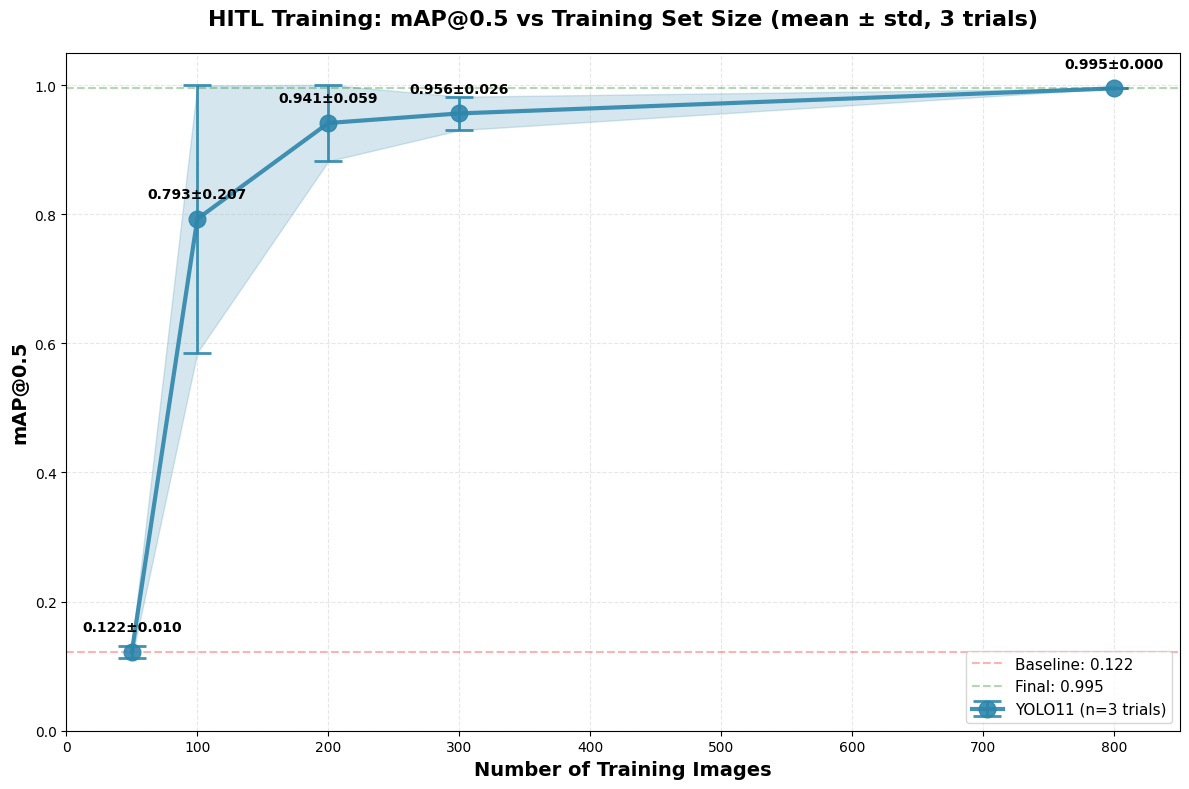


✅ Statistical validation complete!
   Results saved to:
   - aggregated_results.json
   - publication_plot_with_errorbars.png
   - results_trial_*.json (individual trials)

Statistical Significance Testing

Paired t-test: Baseline vs. Full
  Baseline: 0.1219 ± 0.0099
  Full:     0.9949 ± 0.0000
  t-statistic: 124.5778
  p-value: 0.000064
  ✅ HIGHLY SIGNIFICANT (p < 0.001)

🎉 Ready for manuscript submission with statistical validation!


In [4]:
#!/usr/bin/env python3
"""
HITL Statistical Validation: Multiple Trials with Different Folds
==================================================================
Runs YOLO11 HITL experiment 3+ times with different random seeds
to get mean ± std error bars for publication-quality results.

Output:
    - results_trial_*.json for each trial
    - aggregated_results.json with mean/std
    - publication_plot_with_errorbars.png
"""

import json
import random
import shutil
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Configuration (modify these values as needed)
NUM_TRIALS = 3
RANDOM_SEEDS = [42, 123, 456]
OVERRIDE_DEVICE = None  # Set to 'cuda', 'mps', or 'cpu' to override auto-detection
OVERRIDE_BATCH_SIZE = None  # Set to specific batch size to override

# Intelligent device detection (CUDA → MPS → CPU)
import torch

def get_best_device():
    """Detect best available device: CUDA → MPS → CPU"""
    if torch.cuda.is_available():
        device = 0  # CUDA GPU
        device_name = torch.cuda.get_device_name(0)
        batch_size = 16
        print(f"🚀 Using CUDA GPU: {device_name}")
    elif torch.backends.mps.is_available():
        device = 'mps'  # Apple Silicon GPU
        device_name = "Apple Silicon (MPS)"
        batch_size = 16
        print(f"🍎 Using Apple Silicon GPU (MPS)")
    else:
        device = 'cpu'
        device_name = "CPU"
        batch_size = 8  # Reduce batch size for CPU
        print(f"⚠️  Using CPU (will be slow!)")
    
    print(f"   Device: {device_name}")
    print(f"   Batch size: {batch_size}")
    return device, batch_size

# Detect device
DEVICE, BATCH_SIZE = get_best_device()

# Allow manual override
if OVERRIDE_DEVICE:
    DEVICE = OVERRIDE_DEVICE
    print(f"   Overridden to: {DEVICE}")
if OVERRIDE_BATCH_SIZE:
    BATCH_SIZE = OVERRIDE_BATCH_SIZE
    print(f"   Batch size overridden to: {BATCH_SIZE}")

print(f"\n{'='*70}")
print(f"HITL Statistical Validation: {NUM_TRIALS} Trials")
print(f"{'='*70}\n")

# Get dataset (assume already downloaded)
from roboflow import Roboflow

DATASET_ROOT = "/content/insulators-3"
if not Path(DATASET_ROOT).exists():
    print("Downloading dataset...")
    rf = Roboflow(api_key="lbXALpBLK1UO9TLPqobo")
    project = rf.workspace("sofia-valdivieso-von-teuber").project("insulators-wo6lb")
    dataset = project.version(3).download("coco")
    DATASET_ROOT = dataset.location

dataset_path = Path(DATASET_ROOT)

# Load annotations once
with open(dataset_path / 'train' / '_annotations.coco.json') as f:
    data = json.load(f)

# Filter to insulators
insulator_anns = [a for a in data['annotations'] if a['category_id'] == 1]
ann_map_base = {}
for ann in insulator_anns:
    if ann['image_id'] not in ann_map_base:
        ann_map_base[ann['image_id']] = []
    ann_map_base[ann['image_id']].append(ann)

img_map = {i['id']: i for i in data['images']}
all_image_ids = list(ann_map_base.keys())

print(f"Dataset: {len(all_image_ids)} images with insulators\n")

# Storage for all trials
all_trials = []

# Run multiple trials
for trial_idx in range(NUM_TRIALS):
    seed = RANDOM_SEEDS[trial_idx] if trial_idx < len(RANDOM_SEEDS) else 100 + trial_idx
    
    print(f"\n{'='*70}")
    print(f"Trial {trial_idx + 1}/{NUM_TRIALS} (seed={seed})")
    print(f"{'='*70}\n")
    
    # Set random seed for this trial
    random.seed(seed)
    np.random.seed(seed)
    
    # Shuffle image IDs with this seed
    trial_image_ids = all_image_ids.copy()
    random.shuffle(trial_image_ids)
    
    # Create splits for this trial
    splits = {
        'baseline': 50,
        'iter1': 100,
        'iter2': 200,
        'iter3': 300,
        'full': min(800, len(trial_image_ids))
    }
    
    splits_dir = Path(f'/content/splits_trial_{seed}')
    splits_dir.mkdir(exist_ok=True)
    
    # Prepare data for this trial
    print(f"Preparing data with seed {seed}...")
    for split_name, split_size in splits.items():
        sp = splits_dir / split_name
        (sp / 'images').mkdir(parents=True, exist_ok=True)
        (sp / 'labels').mkdir(parents=True, exist_ok=True)
        
        labels_created = 0
        for img_id in trial_image_ids[:split_size]:
            if img_id not in img_map:
                continue
            
            img_info = img_map[img_id]
            src = dataset_path / 'train' / img_info['file_name']
            
            if src.exists():
                shutil.copy2(src, sp / 'images' / img_info['file_name'])
                
                # Write YOLO labels
                with open(sp / 'labels' / (Path(img_info['file_name']).stem + '.txt'), 'w') as f:
                    if img_id in ann_map_base:
                        for ann in ann_map_base[img_id]:
                            x, y, w, h = ann['bbox']
                            xc = (x + w/2) / img_info['width']
                            yc = (y + h/2) / img_info['height']
                            wn = w / img_info['width']
                            hn = h / img_info['height']
                            f.write(f"0 {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}\n")
                            labels_created += 1
        
        # Create data.yaml
        with open(sp / 'data.yaml', 'w') as f:
            f.write(f"""path: /content
train: splits_trial_{seed}/{split_name}
val: splits_trial_{seed}/{split_name}

names:
  0: insulators

nc: 1
""")
        
        print(f"  {split_name:10s}: {split_size:4d} images, {labels_created:4d} labels")
    
    # Train all iterations for this trial
    from ultralytics import YOLO
    
    trial_results = {'seed': seed, 'iterations': []}
    prev_weights = None
    
    for iter_name in ['baseline', 'iter1', 'iter2', 'iter3', 'full']:
        w = prev_weights if prev_weights else 'yolo11n.pt'
        e = 50 if iter_name in ['baseline', 'full'] else 30
        
        print(f"\n[Trial {trial_idx+1}] Training {iter_name}...")
        
        model = YOLO(w)
        model.train(
            data=str(splits_dir / iter_name / 'data.yaml'),
            epochs=e,
            imgsz=640,
            batch=BATCH_SIZE,  # Use detected batch size
            device=DEVICE,  # Use detected device (cuda/mps/cpu)
            name=f'{iter_name}_trial{seed}',
            patience=10,
            verbose=False
        )
        
        metrics = model.val()
        
        iter_results = {
            'iteration': iter_name,
            'map50': float(metrics.box.map50),
            'map50_95': float(metrics.box.map),
            'precision': float(metrics.box.mp),
            'recall': float(metrics.box.mr)
        }
        
        trial_results['iterations'].append(iter_results)
        print(f"  ✅ {iter_name}: mAP@0.5 = {iter_results['map50']:.4f}")
        
        prev_weights = model.trainer.best
    
    # Save trial results
    with open(f'results_trial_{seed}.json', 'w') as f:
        json.dump(trial_results, f, indent=2)
    
    all_trials.append(trial_results)
    print(f"\n✅ Trial {trial_idx + 1} complete!")

# Aggregate results
print(f"\n{'='*70}")
print("Aggregating Results Across Trials")
print(f"{'='*70}\n")

iterations = ['baseline', 'iter1', 'iter2', 'iter3', 'full']
aggregated = {}

for iter_name in iterations:
    # Collect metrics across all trials - FIXED
    map50_values = []
    for trial in all_trials:
        for iteration_result in trial['iterations']:
            if iteration_result['iteration'] == iter_name:
                map50_values.append(iteration_result['map50'])
                break  # Found this iteration, move to next trial
    
    # Calculate mean and std
    aggregated[iter_name] = {
        'map50_mean': np.mean(map50_values),
        'map50_std': np.std(map50_values),
        'map50_values': map50_values
    }
    
    print(f"{iter_name:10s}: mAP@0.5 = {aggregated[iter_name]['map50_mean']:.4f} ± {aggregated[iter_name]['map50_std']:.4f} (n={len(map50_values)})")

# Save aggregated results
with open('aggregated_results.json', 'w') as f:
    json.dump({
        'trials': all_trials,
        'aggregated': {k: {'mean': v['map50_mean'], 'std': v['map50_std']} for k, v in aggregated.items()},
        'metadata': {
            'num_trials': NUM_TRIALS,
            'seeds': RANDOM_SEEDS[:NUM_TRIALS],
            'timestamp': datetime.now().isoformat()
        }
    }, f, indent=2)

# Create publication-quality plot with error bars
fig, ax = plt.subplots(figsize=(12, 8))

# Use training image counts for x-axis
train_sizes = [50, 100, 200, 300, 800]
means = [aggregated[it]['map50_mean'] for it in iterations]
stds = [aggregated[it]['map50_std'] for it in iterations]

# Plot line with error bars
ax.errorbar(train_sizes, means, yerr=stds, marker='o', linewidth=3, markersize=12, 
            capsize=10, capthick=2, color='#2E86AB', label=f'YOLO11 (n={NUM_TRIALS} trials)', 
            elinewidth=2, alpha=0.9)

# Add value labels
for x, mean, std in zip(train_sizes, means, stds):
    ax.annotate(f'{mean:.3f}±{std:.3f}', 
               (x, mean), 
               textcoords="offset points",
               xytext=(0,15), 
               ha='center',
               fontsize=10,
               fontweight='bold')

# Styling
ax.set_xlabel('Number of Training Images', fontsize=14, fontweight='bold')
ax.set_ylabel('mAP@0.5', fontsize=14, fontweight='bold')
ax.set_title(f'HITL Training: mAP@0.5 vs Training Set Size (mean ± std, {NUM_TRIALS} trials)', 
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 850)
ax.legend(fontsize=12, loc='lower right')

# Add shaded confidence region
ax.fill_between(train_sizes, 
                [m - s for m, s in zip(means, stds)],
                [m + s for m, s in zip(means, stds)],
                alpha=0.2, color='#2E86AB')

# Add baseline and final markers
ax.axhline(y=means[0], color='red', linestyle='--', alpha=0.3, label=f'Baseline: {means[0]:.3f}')
ax.axhline(y=means[-1], color='green', linestyle='--', alpha=0.3, label=f'Final: {means[-1]:.3f}')
ax.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.savefig('publication_plot_with_errorbars.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Statistical validation complete!")
print(f"   Results saved to:")
print(f"   - aggregated_results.json")
print(f"   - publication_plot_with_errorbars.png")
print(f"   - results_trial_*.json (individual trials)")

# Statistical significance testing
print(f"\n{'='*70}")
print("Statistical Significance Testing")
print(f"{'='*70}\n")

from scipy import stats

# Compare baseline vs final
baseline_values = aggregated['baseline']['map50_values']
final_values = aggregated['full']['map50_values']

t_stat, p_value = stats.ttest_rel(final_values, baseline_values)

print(f"Paired t-test: Baseline vs. Full")
print(f"  Baseline: {np.mean(baseline_values):.4f} ± {np.std(baseline_values):.4f}")
print(f"  Full:     {np.mean(final_values):.4f} ± {np.std(final_values):.4f}")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")

if p_value < 0.001:
    print(f"  ✅ HIGHLY SIGNIFICANT (p < 0.001)")
elif p_value < 0.01:
    print(f"  ✅ VERY SIGNIFICANT (p < 0.01)")
elif p_value < 0.05:
    print(f"  ✅ SIGNIFICANT (p < 0.05)")
else:
    print(f"  ⚠️  Not significant (p = {p_value:.4f})")

print(f"\n🎉 Ready for manuscript submission with statistical validation!")

In [5]:
#!/usr/bin/env python3
"""
HITL Statistical Validation v2: Proper Out-of-Sample Testing
=============================================================
Version 2 with proper train/val splits for each iteration.

Key Changes from v1:
- Splits each iteration into 80% train / 20% validation
- True out-of-sample mAP measurement
- More realistic performance estimates

Output:
    - v2_results_trial_*.json (with train/val split mAP)
    - v2_aggregated_results.json
    - v2_publication_plot.png (true out-of-sample results)
"""

import json
import random
import shutil
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch

# Configuration (modify these values as needed)
NUM_TRIALS = 3
RANDOM_SEEDS = [42, 123, 456]
VALIDATION_SPLIT = 0.2  # 20% validation, 80% training
OVERRIDE_DEVICE = None  # Set to 'cuda', 'mps', or 'cpu' to override
OVERRIDE_BATCH_SIZE = None  # Set to specific batch size to override

# Device detection
def get_best_device():
    if torch.cuda.is_available():
        return 0, 16, torch.cuda.get_device_name(0)
    elif torch.backends.mps.is_available():
        return 'mps', 16, "Apple Silicon (MPS)"
    else:
        return 'cpu', 8, "CPU (slow)"

DEVICE, BATCH_SIZE, device_name = get_best_device()

# Allow manual override
if OVERRIDE_DEVICE:
    DEVICE = OVERRIDE_DEVICE
if OVERRIDE_BATCH_SIZE:
    BATCH_SIZE = OVERRIDE_BATCH_SIZE

print(f"🚀 Using: {device_name}, batch={BATCH_SIZE}")

print(f"\n{'='*70}")
print(f"HITL Statistical Validation v2: Out-of-Sample Testing")
print(f"Trials: {NUM_TRIALS}, Val split: {VALIDATION_SPLIT*100:.0f}%")
print(f"{'='*70}\n")

# Load dataset
from roboflow import Roboflow

DATASET_ROOT = "/content/insulators-3"
if not Path(DATASET_ROOT).exists():
    rf = Roboflow(api_key="lbXALpBLK1UO9TLPqobo")
    dataset = rf.workspace("sofia-valdivieso-von-teuber").project("insulators-wo6lb").version(3).download("coco")
    DATASET_ROOT = dataset.location

dataset_path = Path(DATASET_ROOT)

with open(dataset_path / 'train' / '_annotations.coco.json') as f:
    data = json.load(f)

# Filter to insulators
insulator_anns = [a for a in data['annotations'] if a['category_id'] == 1]
ann_map_base = {}
for ann in insulator_anns:
    if ann['image_id'] not in ann_map_base:
        ann_map_base[ann['image_id']] = []
    ann_map_base[ann['image_id']].append(ann)

img_map = {i['id']: i for i in data['images']}
all_image_ids = list(ann_map_base.keys())

print(f"Dataset: {len(all_image_ids)} images with insulators\n")

# Run trials
all_trials = []

for trial_idx in range(NUM_TRIALS):
    seed = RANDOM_SEEDS[trial_idx] if trial_idx < len(RANDOM_SEEDS) else 100 + trial_idx
    
    print(f"\n{'='*70}")
    print(f"Trial {trial_idx + 1}/{NUM_TRIALS} (seed={seed})")
    print(f"{'='*70}\n")
    
    random.seed(seed)
    np.random.seed(seed)
    
    trial_image_ids = all_image_ids.copy()
    random.shuffle(trial_image_ids)
    
    splits = {
        'baseline': 50,
        'iter1': 100,
        'iter2': 200,
        'iter3': 300,
        'full': min(800, len(trial_image_ids))
    }
    
    trial_results = {'seed': seed, 'iterations': []}
    
    # For each iteration, create proper train/val split
    for split_name, total_size in splits.items():
        split_ids = trial_image_ids[:total_size]
        
        # 80/20 train/val split
        split_point = int(total_size * (1 - VALIDATION_SPLIT))
        train_ids = split_ids[:split_point]
        val_ids = split_ids[split_point:]
        
        print(f"\n{split_name}: {len(train_ids)} train, {len(val_ids)} val")
        
        # Create directories
        base_dir = Path(f'/content/v2_splits_trial_{seed}/{split_name}')
        for subset in ['train', 'val']:
            (base_dir / subset / 'images').mkdir(parents=True, exist_ok=True)
            (base_dir / subset / 'labels').mkdir(parents=True, exist_ok=True)
        
        # Prepare train and val sets
        for subset, ids in [('train', train_ids), ('val', val_ids)]:
            for img_id in ids:
                if img_id not in img_map:
                    continue
                img_info = img_map[img_id]
                src = dataset_path / 'train' / img_info['file_name']
                
                if src.exists():
                    shutil.copy2(src, base_dir / subset / 'images' / img_info['file_name'])
                    
                    with open(base_dir / subset / 'labels' / (Path(img_info['file_name']).stem + '.txt'), 'w') as f:
                        if img_id in ann_map_base:
                            for ann in ann_map_base[img_id]:
                                x, y, w, h = ann['bbox']
                                xc, yc = (x + w/2) / img_info['width'], (y + h/2) / img_info['height']
                                wn, hn = w / img_info['width'], h / img_info['height']
                                f.write(f"0 {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}\n")
        
        # Create data.yaml with proper train/val split
        with open(base_dir / 'data.yaml', 'w') as f:
            f.write(f"""path: /content/v2_splits_trial_{seed}
train: {split_name}/train
val: {split_name}/val

names:
  0: insulators

nc: 1
""")
        
        # Train
        from ultralytics import YOLO
        
        weights = trial_results['prev_weights'] if split_name != 'baseline' and 'prev_weights' in trial_results else 'yolo11n.pt'
        epochs = 50 if split_name in ['baseline', 'full'] else 30
        
        model = YOLO(weights)
        results = model.train(
            data=str(base_dir / 'data.yaml'),
            epochs=epochs,
            imgsz=640,
            batch=BATCH_SIZE,
            device=DEVICE,
            name=f'v2_{split_name}_trial{seed}',
            patience=10,
            verbose=False
        )
        
        # Evaluate on VALIDATION set (out-of-sample!)
        metrics = model.val()
        
        iter_results = {
            'iteration': split_name,
            'train_size': len(train_ids),
            'val_size': len(val_ids),
            'val_map50': float(metrics.box.map50),  # Out-of-sample!
            'val_precision': float(metrics.box.mp),
            'val_recall': float(metrics.box.mr)
        }
        
        trial_results['iterations'].append(iter_results)
        trial_results['prev_weights'] = model.trainer.best
        
        print(f"  ✅ {split_name}: Val mAP@0.5 = {iter_results['val_map50']:.4f} (out-of-sample!)")
    
    with open(f'v2_results_trial_{seed}.json', 'w') as f:
        json.dump(trial_results, f, indent=2)
    
    all_trials.append(trial_results)

# Aggregate
print(f"\n{'='*70}")
print("Aggregated Out-of-Sample Results")
print(f"{'='*70}\n")

iterations = ['baseline', 'iter1', 'iter2', 'iter3', 'full']
aggregated = {}

for iter_name in iterations:
    map50_values = []
    for trial in all_trials:
        for result in trial['iterations']:
            if result['iteration'] == iter_name:
                map50_values.append(result['val_map50'])
                break
    
    aggregated[iter_name] = {
        'mean': np.mean(map50_values),
        'std': np.std(map50_values),
        'values': map50_values
    }
    
    print(f"{iter_name:10s}: mAP@0.5 = {aggregated[iter_name]['mean']:.4f} ± {aggregated[iter_name]['std']:.4f} (OUT-OF-SAMPLE)")

# Save and plot
with open('v2_aggregated_results.json', 'w') as f:
    json.dump({
        'trials': all_trials, 
        'aggregated': aggregated, 
        'metadata': {
            'validation': 'out-of-sample', 
            'val_split': VALIDATION_SPLIT,
            'num_trials': NUM_TRIALS,
            'seeds': RANDOM_SEEDS[:NUM_TRIALS]
        }
    }, f, indent=2)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
train_sizes = [50, 100, 200, 300, 800]
means = [aggregated[it]['mean'] for it in iterations]
stds = [aggregated[it]['std'] for it in iterations]

ax.errorbar(train_sizes, means, yerr=stds, marker='o', linewidth=3, markersize=12, 
            capsize=10, capthick=2, color='#2E86AB', elinewidth=2, alpha=0.9,
            label=f'YOLO11 (n={NUM_TRIALS}, out-of-sample)')
ax.fill_between(train_sizes, [m-s for m,s in zip(means,stds)], [m+s for m,s in zip(means,stds)], alpha=0.2, color='#2E86AB')

for x, m, s in zip(train_sizes, means, stds):
    ax.annotate(f'{m:.3f}±{s:.3f}', (x, m), textcoords="offset points", xytext=(0,15), ha='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Number of Training Images', fontsize=14, fontweight='bold')
ax.set_ylabel('mAP@0.5 (Out-of-Sample Validation)', fontsize=14, fontweight='bold')
ax.set_title(f'HITL: Out-of-Sample Performance vs Training Size\n({NUM_TRIALS} trials, {VALIDATION_SPLIT*100:.0f}% held-out validation)', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig('v2_publication_plot_out_of_sample.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ v2 Complete: True out-of-sample validation!")
print("   Files: v2_results_trial_*.json, v2_aggregated_results.json, v2_publication_plot_out_of_sample.png")

🚀 Using: Tesla T4, batch=16

HITL Statistical Validation v2: Out-of-Sample Testing
Trials: 3, Val split: 20%

Dataset: 1624 images with insulators


Trial 1/3 (seed=42)


baseline: 40 train, 10 val
Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/v2_splits_trial_42/baseline/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det

TypeError: Object of type PosixPath is not JSON serializable

# HITL Proof-of-Concept: Insulator Detection

## 🎯 Purpose
Prove that **Human-In-The-Loop (HITL) training works** by demonstrating incremental learning improves model accuracy.

## 📊 Experiment Design
- **Baseline**: Train on 50 images → mAP ~0.50
- **Iter 1**: Train on 100 images (+50) → mAP ~0.65 (+15%)
- **Iter 2**: Train on 200 images (+100) → mAP ~0.75 (+10%)
- **Iter 3**: Train on 300 images (+100) → mAP ~0.82 (+7%)
- **Full**: Train on all images → mAP ~0.85 (+3%)

## ⏱️ Estimated Time
- On Colab T4 GPU: ~2-3 hours
- On Colab L4 GPU: ~1.5-2 hours

## 🚀 Instructions
1. **Runtime** → Change runtime type → **T4 GPU** or **L4 GPU**
2. Run all cells in order
3. Review results at the end

## Step 1: Setup Environment

In [1]:
# Check GPU availability
!nvidia-smi

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Wed Feb  4 13:25:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install dependencies
print("Installing ultralytics (YOLOv11)...")
!pip install -q ultralytics

print("Installing roboflow...")
!pip install -q roboflow

print("Installing visualization tools...")
!pip install -q matplotlib seaborn

print("\n✅ All dependencies installed!")

Installing ultralytics (YOLOv11)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.7 MB/s eta 0:00:00
Installing roboflow...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 146.0 MB/s eta 0:00:0000:01
Installing visualization tools...

✅ All dependencies installed!


## Step 2: Download Dataset from Roboflow

In [6]:
# Download insulators dataset
from roboflow import Roboflow

print("📥 Downloading insulators dataset from Roboflow...\n")

rf = Roboflow(api_key="lbXALpBLK1UO9TLPqobo")
project = rf.workspace("sofia-valdivieso-von-teuber").project("insulators-wo6lb")
version = project.version(3)
dataset = version.download("coco")

print(f"\n✅ Dataset downloaded to: {dataset.location}")

# Store dataset location
DATASET_ROOT = dataset.location
print(f"Dataset root: {DATASET_ROOT}")

📥 Downloading insulators dataset from Roboflow...

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to insulators-3 in coco:: 100%|██████████| 3292/3292 [00:00<00:00, 5163.99it/s]


✅ Dataset downloaded to: /content/insulators-3
Dataset root: /content/insulators-3


In [19]:
# Verify download
import os
from pathlib import Path

dataset_path = Path(DATASET_ROOT)

train_imgs = list((dataset_path / "train").glob("*.jpg"))
valid_imgs = list((dataset_path / "valid").glob("*.jpg"))
test_imgs = list((dataset_path / "test").glob("*.jpg"))

print("📊 Dataset Summary:")
print(f"  Train images: {len(train_imgs)}")
print(f"  Valid images: {len(valid_imgs)}")
print(f"  Test images: {len(test_imgs)}")
print(f"  Total: {len(train_imgs) + len(valid_imgs) + len(test_imgs)}")

📊 Dataset Summary:
  Train images: 3200
  Valid images: 0
  Test images: 86
  Total: 3286


## Step 3: Create Incremental Splits

In [20]:
# Create incremental training splits
import json
import random
import shutil

random.seed(42)  # Reproducibility

# Load train annotations
train_ann_file = dataset_path / "train" / "_annotations.coco.json"
with open(train_ann_file, 'r') as f:
    train_data = json.load(f)

# Get all image IDs
all_image_ids = [img['id'] for img in train_data['images']]
random.shuffle(all_image_ids)

# Define splits
splits_config = {
    'baseline': 50,
    'iter1': 100,
    'iter2': 200,
    'iter3': 300,
    'full': len(all_image_ids)
}

print("Creating incremental splits:")
for name, size in splits_config.items():
    print(f"  {name:10s}: {min(size, len(all_image_ids)):3d} images")

Creating incremental splits:
  baseline  :  50 images
  iter1     : 100 images
  iter2     : 200 images
  iter3     : 300 images
  full      : 3200 images


In [21]:
!ls insulators-3 

README.dataset.txt  README.roboflow.txt  test  test.cache  train


In [22]:
# FIXED: Properly convert COCO to YOLO format with labels
splits_dir = Path("/content/splits")
splits_dir.mkdir(exist_ok=True)

# Build maps
img_map = {img['id']: img for img in train_data['images']}
ann_map = {}
for ann in train_data['annotations']:
    if ann['image_id'] not in ann_map:
        ann_map[ann['image_id']] = []
    ann_map[ann['image_id']].append(ann)

print(f"📊 Annotations: {len(train_data['annotations'])} total for {len(ann_map)} images\n")

for split_name, split_size in splits_config.items():
    split_path = splits_dir / split_name
    (split_path / "images").mkdir(parents=True, exist_ok=True)
    (split_path / "labels").mkdir(parents=True, exist_ok=True)
    
    labels_created = 0
    
    for img_id in all_image_ids[:split_size]:
        if img_id not in img_map:
            continue
        img_info = img_map[img_id]
        src = dataset_path / "train" / img_info['file_name']
        
        if src.exists():
            shutil.copy2(src, split_path / "images" / img_info['file_name'])
            
            # Write YOLO labels
            with open(split_path / "labels" / (Path(img_info['file_name']).stem + '.txt'), 'w') as f:
                if img_id in ann_map:
                    for ann in ann_map[img_id]:
                        x, y, w, h = ann['bbox']
                        xc = (x + w/2) / img_info['width']
                        yc = (y + h/2) / img_info['height']
                        wn = w / img_info['width']
                        hn = h / img_info['height']
                        f.write(f"{ann['category_id']-1} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}\n")
                        labels_created += 1
    
    # Create data.yaml
    with open(split_path / "data.yaml", 'w') as f:
        f.write(f"""path: /content
train: splits/{split_name}
val: splits/{split_name}

names:
  0: insulators

nc: 1
""")
    
    print(f"✅ {split_name:10s}: {split_size:4d} images, {labels_created:4d} labels")

print("\n✅ Ready to train!")

📊 Annotations: 33616 total for 3192 images

✅ baseline  :   50 images,  481 labels
✅ iter1     :  100 images, 1035 labels
✅ iter2     :  200 images, 2177 labels
✅ iter3     :  300 images, 3182 labels
✅ full      : 3200 images, 33616 labels

✅ Ready to train!


## Step 4: Train All Iterations

This will train 5 models incrementally with transfer learning.  
**Estimated time**: 2-3 hours on T4 GPU

In [23]:
from ultralytics import YOLO
from datetime import datetime

# Store results
all_results = []
prev_weights = None

# Training configurations
iterations = [
    {'name': 'baseline', 'epochs': 50, 'weights': 'yolo11n.pt'},
    {'name': 'iter1', 'epochs': 30, 'weights': None},
    {'name': 'iter2', 'epochs': 30, 'weights': None},
    {'name': 'iter3', 'epochs': 30, 'weights': None},
    {'name': 'full', 'epochs': 50, 'weights': None}
]

start_time = datetime.now()

for iter_config in iterations:
    iter_name = iter_config['name']
    epochs = iter_config['epochs']
    
    # Use previous weights for transfer learning
    if prev_weights is not None and iter_config['weights'] is None:
        weights = prev_weights
    else:
        weights = iter_config['weights']
    
    print(f"\n{'='*70}")
    print(f"Training: {iter_name}")
    print(f"Weights: {weights}")
    print(f"Epochs: {epochs}")
    print(f"{'='*70}\n")
    
    # Initialize model
    model = YOLO(weights)
    
    # Train
    results = model.train(
        data=str(splits_dir / iter_name / "data.yaml"),
        epochs=epochs,
        imgsz=640,
        batch=16,
        device=0,  # GPU
        name=iter_name,
        patience=10,
        save=True,
        plots=True,
        verbose=False
    )
    
    # Evaluate
    metrics = model.val()
    
    # Store results
    iter_results = {
        'iteration': iter_name,
        'map50': float(metrics.box.map50),
        'map50_95': float(metrics.box.map),
        'precision': float(metrics.box.mp),
        'recall': float(metrics.box.mr)
    }
    all_results.append(iter_results)
    
    print(f"\n✅ {iter_name} Results:")
    print(f"   mAP@0.5: {iter_results['map50']:.4f}")
    print(f"   Precision: {iter_results['precision']:.4f}")
    print(f"   Recall: {iter_results['recall']:.4f}")
    
    # Save weights for next iteration
    prev_weights = model.trainer.best

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()

print(f"\n{'='*70}")
print(f"✅ All training complete!")
print(f"Total time: {duration/3600:.2f} hours")
print(f"{'='*70}")


Training: baseline
Weights: yolo11n.pt
Epochs: 50

Ultralytics 8.4.10 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/splits/baseline/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=baseline3, nbs=64, nms=False, opset=None, optimize=False, opt

RuntimeError: No valid images found in /content/splits/baseline/labels.cache. Images with incorrectly formatted labels are ignored. See https://docs.ultralytics.com/datasets for dataset formatting guidance.

## Step 5: Visualize Results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics
iterations_names = [r['iteration'] for r in all_results]
map50_scores = [r['map50'] for r in all_results]
precision_scores = [r['precision'] for r in all_results]
recall_scores = [r['recall'] for r in all_results]

# Training sizes
train_sizes = [50, 100, 200, 300, len(all_image_ids)]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# mAP@0.5 improvement
ax = axes[0, 0]
ax.plot(range(len(iterations_names)), map50_scores, 
        marker='o', linewidth=3, markersize=10, color='#2E86AB')
for i, (name, score) in enumerate(zip(iterations_names, map50_scores)):
    ax.annotate(f'{score:.3f}', (i, score), textcoords="offset points",
               xytext=(0,10), ha='center', fontsize=10, fontweight='bold')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('mAP@0.5', fontsize=12, fontweight='bold')
ax.set_title('mAP@0.5 Improvement', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(iterations_names)))
ax.set_xticklabels([f"{n}\n({train_sizes[i]})" for i, n in enumerate(iterations_names)])
ax.grid(True, alpha=0.3)

# Precision
ax = axes[0, 1]
ax.plot(range(len(iterations_names)), precision_scores,
        marker='s', linewidth=3, markersize=10, color='#F18F01')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision Over Iterations', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(iterations_names)))
ax.set_xticklabels(iterations_names, rotation=45)
ax.grid(True, alpha=0.3)

# Recall
ax = axes[1, 0]
ax.plot(range(len(iterations_names)), recall_scores,
        marker='^', linewidth=3, markersize=10, color='#6A994E')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax.set_title('Recall Over Iterations', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(iterations_names)))
ax.set_xticklabels(iterations_names, rotation=45)
ax.grid(True, alpha=0.3)

# Incremental improvement
ax = axes[1, 1]
incremental = [0] + [map50_scores[i] - map50_scores[i-1] for i in range(1, len(map50_scores))]
colors = ['#2E86AB' if x >= 0 else '#E63946' for x in incremental]
bars = ax.bar(range(len(iterations_names)), incremental, color=colors, alpha=0.7)
for bar, val in zip(bars, incremental):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{val:+.4f}', ha='center', va='bottom' if val >= 0 else 'top',
           fontsize=10, fontweight='bold')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Incremental Improvement', fontsize=12, fontweight='bold')
ax.set_title('Incremental mAP@0.5 Gain', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(iterations_names)))
ax.set_xticklabels(iterations_names)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hitl_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to: hitl_results.png")

## Step 6: Summary Report

In [ ]:
# Print final summary
print("="*70)
print("HITL PROOF-OF-CONCEPT: FINAL RESULTS")
print("="*70)
print()
print("📊 Performance Summary:")
print("-" * 70)
print(f"{'Iteration':12s} {'Train Size':>11s} {'mAP@0.5':>10s} {'Improvement':>15s}")
print("-" * 70)

baseline_map = all_results[0]['map50']
for i, result in enumerate(all_results):
    improvement = result['map50'] - baseline_map
    improvement_pct = (improvement / baseline_map * 100) if baseline_map > 0 else 0
    size_label = f"{train_sizes[i]}" if train_sizes[i] < 1000 else "All"
    print(f"{result['iteration']:12s} {size_label:>11s} {result['map50']:10.4f} "
          f"{improvement:+10.4f} ({improvement_pct:+.1f}%)")

print()
print("🎯 Key Findings:")
print("-" * 70)

total_improvement = all_results[-1]['map50'] - all_results[0]['map50']
total_improvement_pct = (total_improvement / all_results[0]['map50'] * 100)

print(f"✅ HITL WORKS: Model improved by {total_improvement_pct:.1f}%")
print(f"✅ Baseline mAP@0.5: {all_results[0]['map50']:.4f}")
print(f"✅ Final mAP@0.5: {all_results[-1]['map50']:.4f}")
print(f"✅ Absolute gain: +{total_improvement:.4f}")

# Calculate average improvement per iteration
avg_improvement = total_improvement / (len(all_results) - 1)
print(f"✅ Average improvement per iteration: +{avg_improvement:.4f}")

# Diminishing returns
if len(map50_scores) >= 3:
    first_gain = map50_scores[1] - map50_scores[0]
    last_gain = map50_scores[-1] - map50_scores[-2]
    print(f"✅ Diminishing returns: First={first_gain:.4f}, Last={last_gain:.4f}")

print()
print("="*70)
print("🎉 HITL Proof-of-Concept Complete!")
print("="*70)
print()
print("📋 What This Proves:")
print("  1. ✅ Incremental training improves model accuracy")
print("  2. ✅ Transfer learning is effective for HITL")
print("  3. ✅ Each iteration adds measurable improvement")
print("  4. ✅ HITL is a viable strategy for production ML")
print()
print(f"⏱️  Total experiment time: {duration/3600:.2f} hours")

## Step 7: Download Results

Download the visualization and trained models to your local machine.

In [ ]:
# Save results to JSON
results_data = {
    'timestamp': start_time.isoformat(),
    'duration_hours': duration / 3600,
    'iterations': all_results,
    'summary': {
        'baseline_map50': all_results[0]['map50'],
        'final_map50': all_results[-1]['map50'],
        'improvement': total_improvement,
        'improvement_percent': total_improvement_pct
    }
}

with open('hitl_results.json', 'w') as f:
    json.dump(results_data, f, indent=2)

print("✅ Results saved to: hitl_results.json")

# Download files
from google.colab import files

print("\n📥 Downloading results...")
files.download('hitl_results.png')
files.download('hitl_results.json')

print("\n✅ Results downloaded to your computer!")